In [3]:

import timeit
from tqdm import tqdm
import re
import sympy as sp
import vector
import math
import numpy as np
import awkward as ak
import uproot as ut
import git
import sys
import os
%load_ext autoreload
%autoreload 2


sys.path.append(git.Repo('.', search_parent_directories=True).working_tree_dir)
from utils import *

In [4]:
fname = "/eos/uscms/store/user/ekoenig/6BAnalysis/NTuples/2018/SR/NN_Higgs/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_10M/output/ntuple_0.root"
tree = Tree(fname)


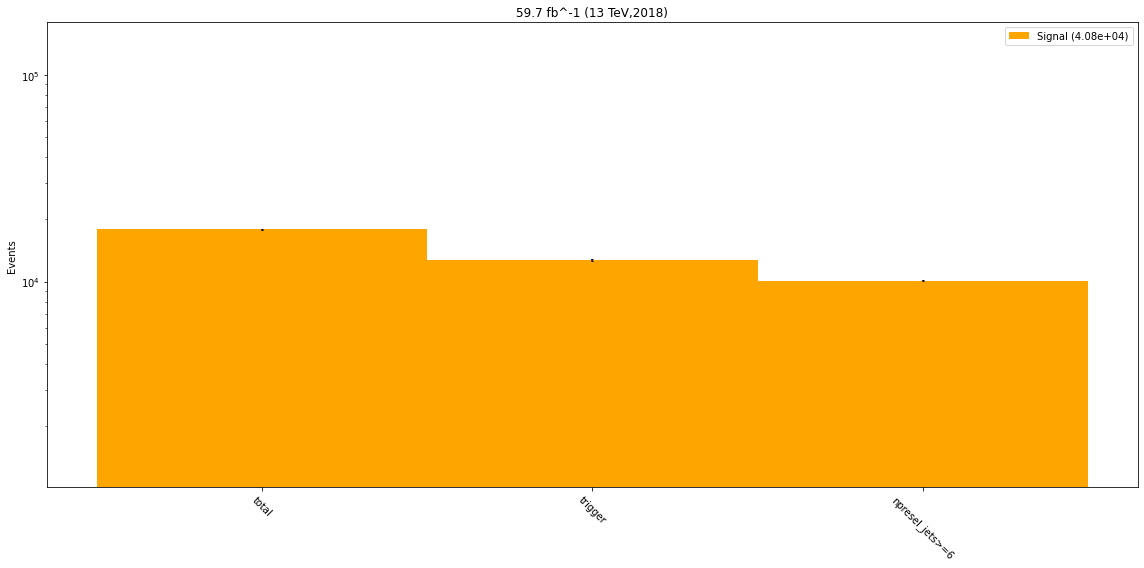

In [5]:
study.cutflow([tree])


# Prep Features


In [38]:
def get_higgsId(signalId):
    hx = (signalId == 0) | (signalId == 1)
    hy1 = (signalId == 2) | (signalId == 3)
    hy2 = (signalId == 4) | (signalId == 5)
    return (1*hx+2*hy1+3*hy2) - 1


def get_features(jets):
    names = ['m', 'pt', 'eta', 'phi']
    return jets[names]


def get_labels(jets):
    names = ['signalId']
    labels = jets[names]
    higgsId = get_higgsId(labels.signalId)
    from_higgs = higgsId > -1
    is_signal = labels.signalId > -1
    return join_fields(labels, higgsId=higgsId, from_higgs=from_higgs, is_signal=is_signal)


def MinMaxScaler(array):
    maxim, minim = ak.max(array, axis=None), ak.min(array, axis=None)
    return (array - minim)/(maxim-minim)


def AvgStdScaler(array):
    avg, std = ak.mean(array, axis=None), ak.std(array, axis=None)
    return (array - avg)/std


def scale_features(features, scaler=AvgStdScaler):
    unzipped = unzip_records(features)
    for field, array in unzipped.items():
        unzipped[field] = scaler(array)
    return ak.zip(unzipped, depth_limit=1)


def reshape_features(features):
    nfeatures = len(features.fields)
    maxjets = ak.max(ak.count(features[features.fields[0]],axis=-1))
    array = ak.concatenate([features[field][:, :, None]
                           for field in features.fields], axis=-1)

    maskint = np.int64(ak.max(array) + 128)
    array = ak.fill_none(ak.pad_none(
        array, maxjets, axis=-2, clip=True), ak.Array(nfeatures*[maskint])).to_numpy()

    return array, maxjets, nfeatures, maskint

def reshape_target(target):
    return ak.concatenate([target[field][:,None] for field in target.fields],axis=-1).to_numpy()


In [13]:
jets = get_collection(tree, 'jet', named=False)
jets = reorder_collection(jets,ak.argsort(-jets.pt,axis=-1))

In [14]:
target = ak.zip(calc_sphericity(jets.pt,jets.eta,jets.phi,jets.m))
target = join_fields(target,**calc_asymmetry(jets.pt,jets.eta,jets.phi,jets.m))

In [16]:
features = get_features(jets)
labels = get_labels(jets)

In [17]:
scaled_features = scale_features(features, MinMaxScaler)
scaled_target = scale_features(target,MinMaxScaler)


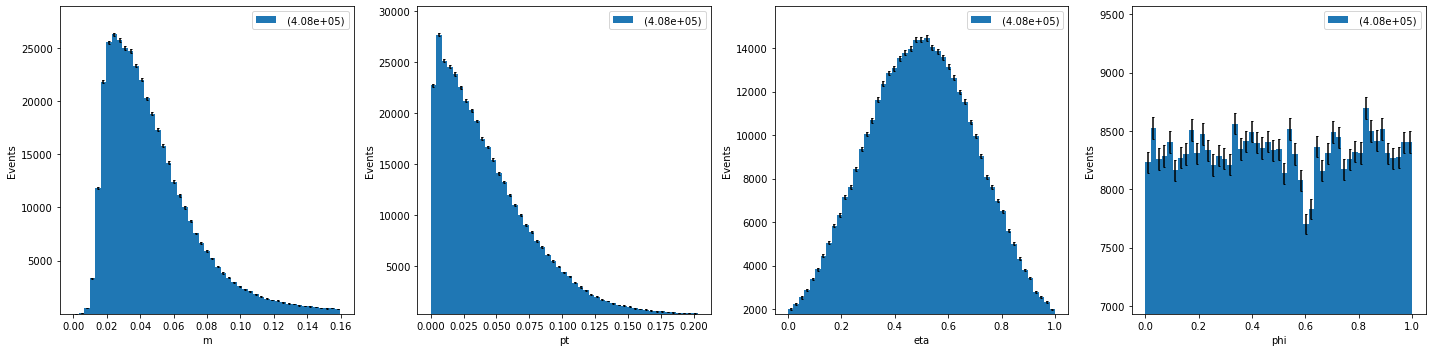

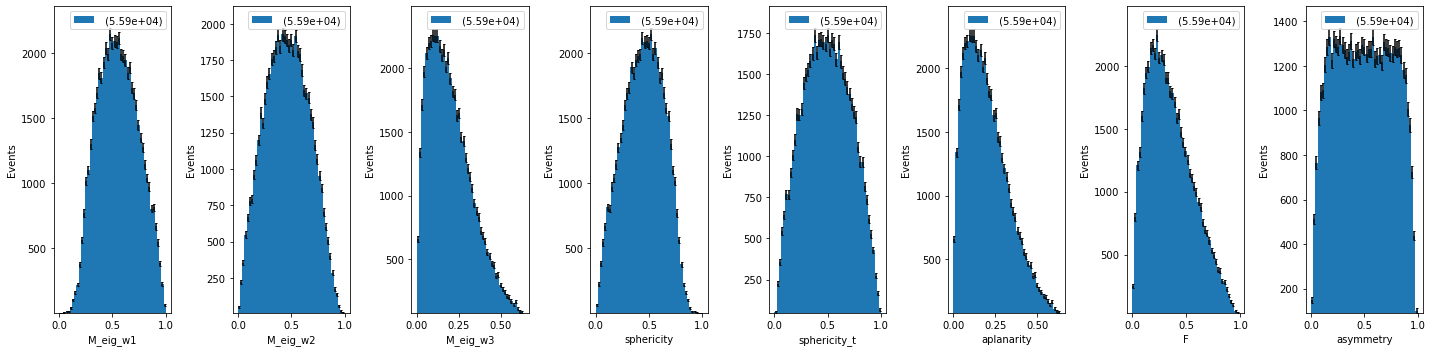

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, field in enumerate(scaled_features.fields):
    hist_multi([scaled_features[field]],
               xlabel=field, figax=(fig, axs.flat[i]))
fig.tight_layout()

fig, axs = plt.subplots(nrows=1, ncols=len(scaled_target.fields), figsize=(20, 5))
for i, field in enumerate(scaled_target.fields):
    hist_multi([scaled_target[field]],
               xlabel=field, figax=(fig, axs.flat[i]))
fig.tight_layout()

In [30]:
data, maxjets, nfeatures, maskint = reshape_features(scaled_features)
targets = reshape_target(scaled_target)
maxjets, nfeatures, maskint


(15, 4, 129)

In [44]:
scaled_target.fields

['M_eig_w1',
 'M_eig_w2',
 'M_eig_w3',
 'sphericity',
 'sphericity_t',
 'aplanarity',
 'F',
 'asymmetry']

# Build NN


In [41]:
def plot_regression(y, pred, tag="Testing Set"):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    hist_multi([y, pred], xlabel="Target", labels=[
               "Actual", "Predicited"], ratio=True, title=tag, figax=(fig, axs[0]))

    error = pred-y
    hist_multi([error], xlabel="Difference", title=tag, figax=(fig, axs[1]))


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [64]:
r_X_train, r_X_test, y_train, y_test = train_test_split(
    data, targets[:,[5,7]], test_size=0.2, shuffle=True)


In [70]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value=maskint, input_shape=(None, nfeatures)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(2, activation='linear'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, None, 4)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 128)         68096     
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 60)                7740      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 122       
Total params: 207,542
Trainable params: 207,542
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(loss='mse', optimizer='adam')


In [72]:
history = model.fit(
    r_X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=100,
    verbose=1
)


Epoch 1/5
403/403 [==============================] - 24s 48ms/step - loss: 0.0151 - val_loss: 0.0102
Epoch 2/5
403/403 [==============================] - 17s 42ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 3/5
403/403 [==============================] - 17s 43ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 4/5
403/403 [==============================] - 17s 43ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 5/5
403/403 [==============================] - 18s 45ms/step - loss: 0.0092 - val_loss: 0.0093


In [73]:
y_pred = model.predict(r_X_test)


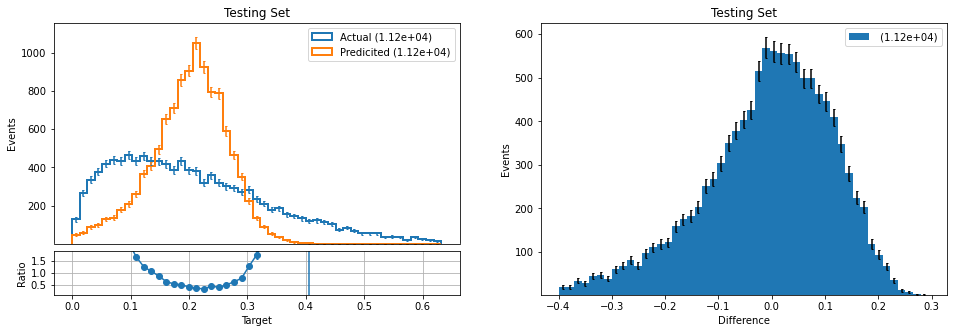

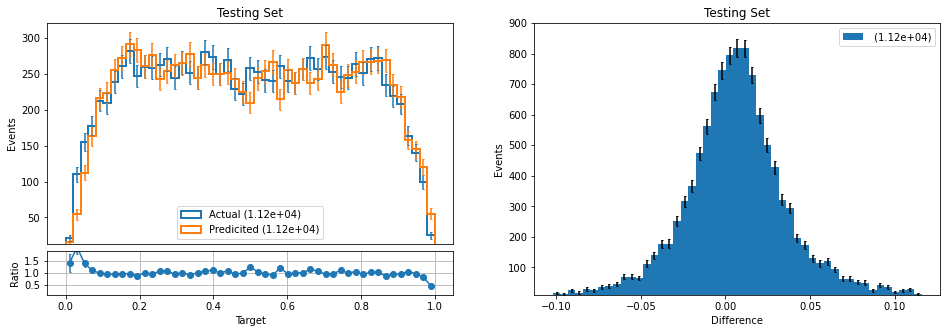

In [74]:
plot_regression(y_test[:,0], y_pred[:,0])
plot_regression(y_test[:,1], y_pred[:,1])


In [122]:
y_pred = model.predict(r_X_train)


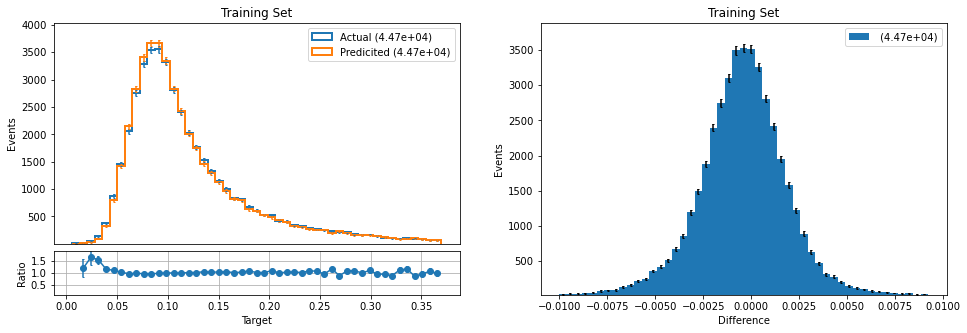

In [123]:
plot_regression(y_train, y_pred, 'Training Set')
